# **Pokemón Diffusion Overfitting<a id="top"></a>**

<i><small>**Alumno:** Alejandro Pequeño Lizcano</small></i></div>

---

**Objetivo:** 
Este notebook tiene como objetivo forzar el overfitting de un modelo de difusión para poder analizar su comportamiento y entender cómo se comporta en un entorno controlado y poder arreglar posibles fallos en el código. De modo que si se consigue forzar el overfitting, entonces se puede congraciar que el modelo de difusión está bien implementado.

- [0. Imports](#-0.-Imports)

- [1. Dataset](#-1.-Dataset)
    - [1.1. Predataset](##-1.1.-Predataset)
    - [1.2. Dataset](##-1.2.-Dataset)

- [2. Modelo de Difusión](#-2.-Modelo-de-Difusión)
    - [2.1. Forward Diffusion](##-2.1.-Forward-Diffusion)
    - [2.2. Reverse Diffusion](##-2.2.-Reverse-Diffusion)
    - [2.3. Train Diffusion Model](##-2.3.-Train-Diffusion-Model)

---

# 0. Imports

In [1]:
# Import necessary libraries
# =====================================================================
import random
import configparser
from src.model.build_model import build_unet
from src.utils import *
from src.utils.config import parse_config
from src.visualization import visualize
from src.model.diffusion_funcionality import *
from src.model.model_callbacks import *

2024-06-14 23:39:42.653707: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-14 23:39:42.682642: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-14 23:39:43.928078: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-14 23:39:43.931764: I external/local_xla/x

In [2]:
# Use the GPU
# =====================================================================
gpus_list = tf.config.list_physical_devices("GPU")
gpu = gpus_list[0]
tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs Available: ", gpus_list)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(CONFIG_PATH)

hyperparameters = parse_config(config, "hyperparameters")

IMG_SIZE = hyperparameters["img_size"]
NUM_CLASSES = hyperparameters["num_classes"]
BATCH_SIZE = hyperparameters["batch_size"]
EPOCHS = hyperparameters["epochs"] = 100
TIMESTEPS = hyperparameters["timesteps"]
SCHEDULER = hyperparameters["scheduler"]
BETA_START = hyperparameters["beta_start"]
BETA_END = hyperparameters["beta_end"]
S = hyperparameters["s"]

- The shape of the dataset is: (32, 64, 64, 3) => batch_size: 32, height: 64, width: 64, channels: 3
- The shape of the dataset labels is: (32, 18) => batch_size: 32, number of labels: 18


2024-06-14 23:39:44.641825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


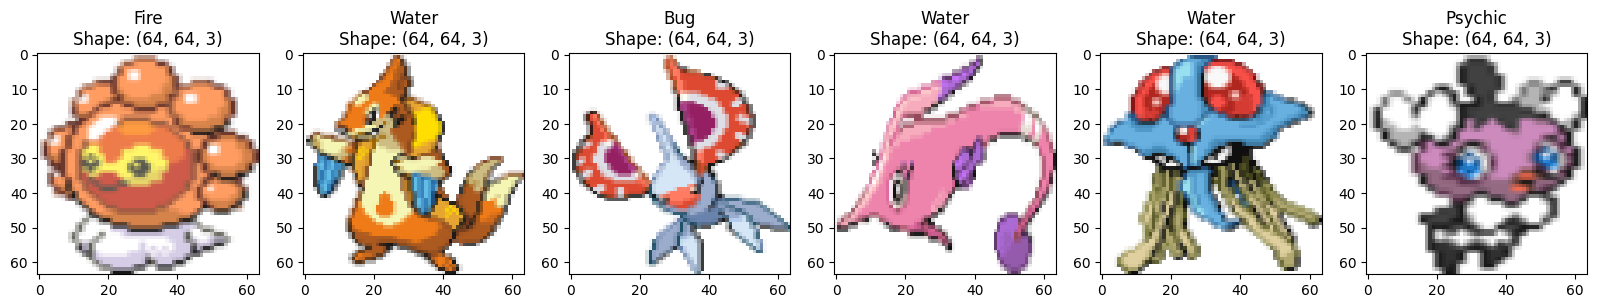

2024-06-14 23:39:46.014492: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset/size{IMG_SIZE}x{IMG_SIZE}_batch{BATCH_SIZE}"
poke_dataset = tf.data.Dataset.load(path=dataset_path, compression="GZIP")

# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

# Visualize the dataset
visualize.plot_images_batch(dataset_tf=poke_dataset, n=6)

<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(32, 64, 64, 3)
(32, 18)


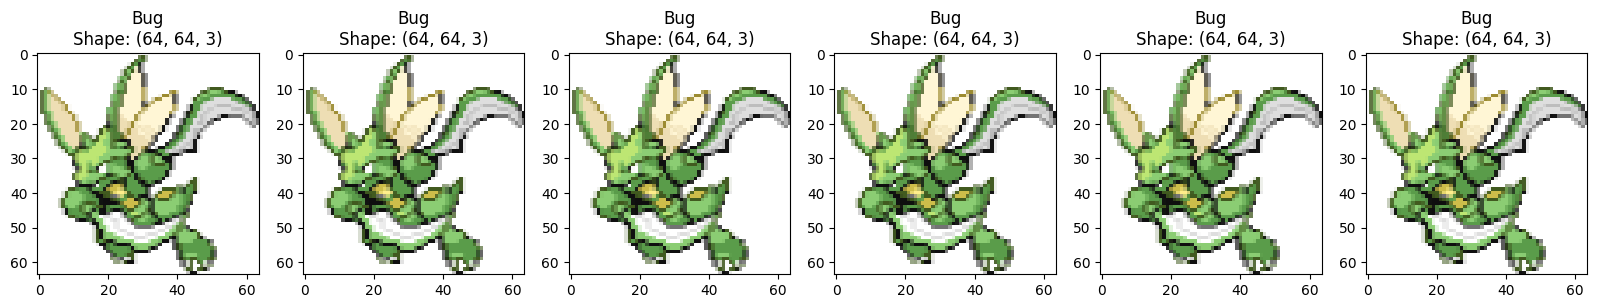

2024-06-14 23:39:53.996221: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-14 23:39:53.996991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
# get one batch of the dataset
dataset_example = poke_dataset.take(1)

# get one specific image of the batch
for img, label in dataset_example:
    random_index = random.randint(0, BATCH_SIZE - 1)
    img_example = img[random_index]
    label_example = label[random_index]
    break

# expand the items to the batch size
img_example = np.expand_dims(img_example, axis=0)
label_example = np.expand_dims(label_example, axis=0)

dataset_overfitting = tf.data.Dataset.from_tensor_slices((img_example, label_example))

n_images = len(poke_dataset) * BATCH_SIZE
dataset_overfitting = dataset_overfitting.repeat(n_images).batch(BATCH_SIZE)

for img, label in dataset_overfitting:
    print(type(img), type(label))
    print(img.shape)
    print(label.shape)
    break

for img, label in dataset_overfitting.take(1):
    label_example = label[0]
    visualize.plot_images_batch(dataset_tf=dataset_overfitting)

In [11]:
# Create the model
# =====================================================================
u_net = build_unet(IMG_SIZE, NUM_CLASSES)
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = DiffusionModel(
    u_net, IMG_SIZE, NUM_CLASSES, TIMESTEPS, BETA_START, BETA_END, S, SCHEDULER
)

# Compile the model
# =====================================================================
model.compile(loss=loss_fn, optimizer=optimizer, metrics=["mae"])

Epoch 1/100


I0000 00:00:1718408413.210911   78832 service.cc:145] XLA service 0x7e4768002c20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718408413.210939   78832 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-06-14 23:40:13.632470: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1718408414.034031   78832 random_ops.cc:59] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform/RandomUniform
W0000 00:00:1718408414.122921   78832 random_ops.cc:105] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform_1
2024-06-14 23:40:15.215

  1/127 ━━━━━━━━━━━━━━━━━━━━ 1:32:27 44s/step - mae: 1.1798 - loss: 2.2064

I0000 00:00:1718408445.202256   78832 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


127/127 ━━━━━━━━━━━━━━━━━━━━ 63s 153ms/step - mae: 0.7190 - loss: 0.8741
Epoch 2/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - mae: 0.3747 - loss: 0.2630
Epoch 3/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - mae: 0.3062 - loss: 0.1862
Epoch 4/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - mae: 0.2705 - loss: 0.1511
Epoch 5/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - mae: 0.2477 - loss: 0.1306
Epoch 6/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - mae: 0.2358 - loss: 0.1223
Epoch 7/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - mae: 0.2190 - loss: 0.1071
Epoch 8/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 152ms/step - mae: 0.1975 - loss: 0.0893
Epoch 9/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - mae: 0.1834 - loss: 0.0783
Epoch 10/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - mae: 0.1693 - loss: 0.0658
Epoch 11/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - mae: 0.1572 - loss: 0.0582
Epoch 12/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - mae: 0.1469 - lo

Sampling sprite...: 100%|██████████| 999/999 [01:24<00:00, 11.76it/s]


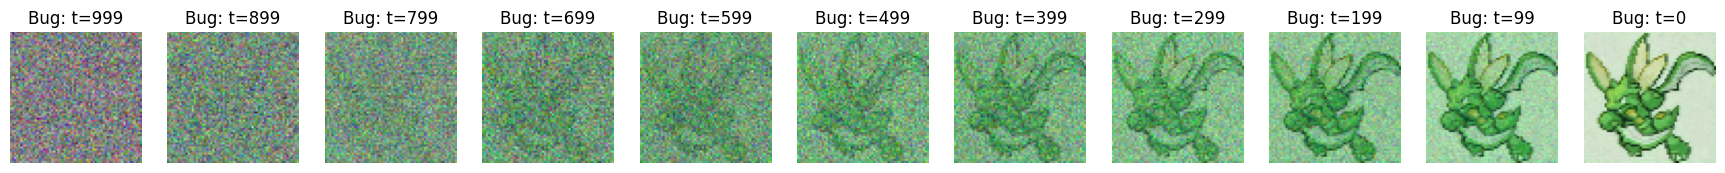

127/127 ━━━━━━━━━━━━━━━━━━━━ 105s 832ms/step - mae: 0.1020 - loss: 0.0247
Epoch 21/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 152ms/step - mae: 0.1006 - loss: 0.0254
Epoch 22/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - mae: 0.0948 - loss: 0.0209
Epoch 23/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - mae: 0.0864 - loss: 0.0178
Epoch 24/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - mae: 0.0890 - loss: 0.0198
Epoch 25/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - mae: 0.0842 - loss: 0.0167
Epoch 26/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - mae: 0.0869 - loss: 0.0187
Epoch 27/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - mae: 0.0946 - loss: 0.0229
Epoch 28/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - mae: 0.0815 - loss: 0.0166
Epoch 29/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - mae: 0.0774 - loss: 0.0145
Epoch 30/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - mae: 0.0733 - loss: 0.0131
Epoch 31/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - mae: 0.

Sampling sprite...: 100%|██████████| 999/999 [01:26<00:00, 11.57it/s]


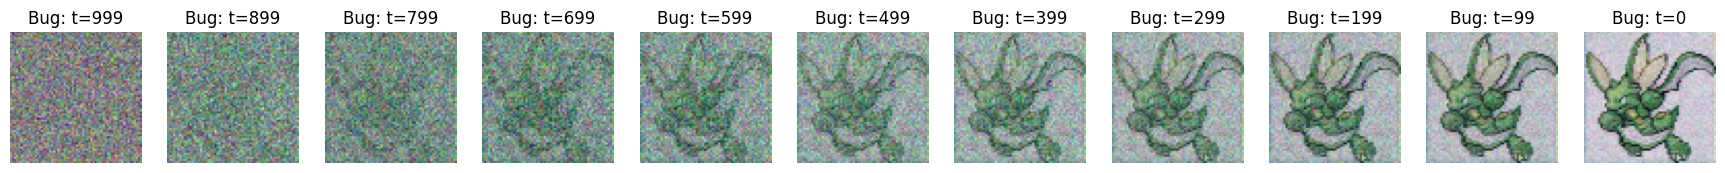

127/127 ━━━━━━━━━━━━━━━━━━━━ 107s 846ms/step - mae: 0.0653 - loss: 0.0111
Epoch 41/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - mae: 0.0649 - loss: 0.0111
Epoch 42/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - mae: 0.0605 - loss: 0.0092
Epoch 43/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - mae: 0.0583 - loss: 0.0083
Epoch 44/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - mae: 0.0643 - loss: 0.0101
Epoch 45/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - mae: 0.0606 - loss: 0.0094
Epoch 46/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - mae: 0.0715 - loss: 0.0133
Epoch 47/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - mae: 0.0616 - loss: 0.0103
Epoch 48/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - mae: 0.0591 - loss: 0.0093
Epoch 49/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 152ms/step - mae: 0.0579 - loss: 0.0084
Epoch 50/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - mae: 0.0649 - loss: 0.0116
Epoch 51/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - mae: 0.

Sampling sprite...: 100%|██████████| 999/999 [01:25<00:00, 11.67it/s]


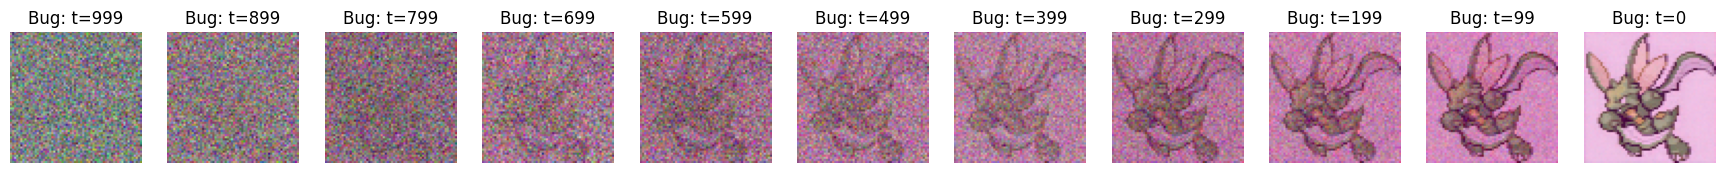

127/127 ━━━━━━━━━━━━━━━━━━━━ 106s 840ms/step - mae: 0.0594 - loss: 0.0091
Epoch 61/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - mae: 0.0531 - loss: 0.0075
Epoch 62/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - mae: 0.0534 - loss: 0.0076
Epoch 63/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - mae: 0.0524 - loss: 0.0074
Epoch 64/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - mae: 0.0513 - loss: 0.0071
Epoch 65/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - mae: 0.0589 - loss: 0.0094
Epoch 66/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - mae: 0.0568 - loss: 0.0086
Epoch 67/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - mae: 0.0560 - loss: 0.0082
Epoch 68/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - mae: 0.0598 - loss: 0.0100
Epoch 69/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - mae: 0.0488 - loss: 0.0066
Epoch 70/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - mae: 0.0479 - loss: 0.0053
Epoch 71/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - mae: 0.

Sampling sprite...: 100%|██████████| 999/999 [01:23<00:00, 11.91it/s]


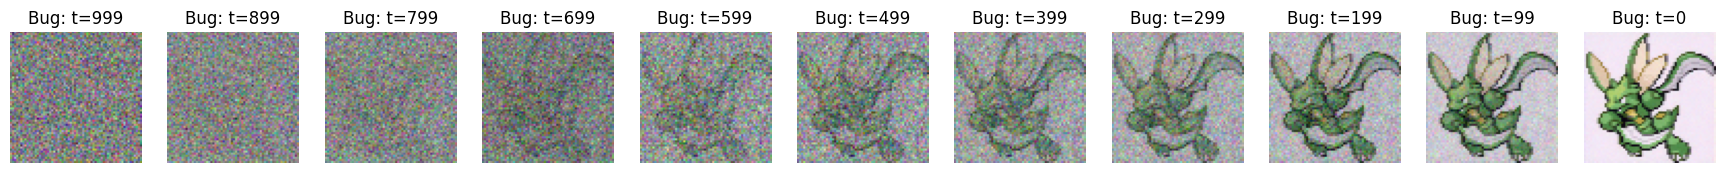

127/127 ━━━━━━━━━━━━━━━━━━━━ 104s 825ms/step - mae: 0.0456 - loss: 0.0054
Epoch 81/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - mae: 0.0481 - loss: 0.0067
Epoch 82/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - mae: 0.0451 - loss: 0.0057
Epoch 83/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - mae: 0.0523 - loss: 0.0079
Epoch 84/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - mae: 0.0480 - loss: 0.0064
Epoch 85/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - mae: 0.0397 - loss: 0.0042
Epoch 86/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - mae: 0.0474 - loss: 0.0060
Epoch 87/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - mae: 0.0422 - loss: 0.0048
Epoch 88/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - mae: 0.0553 - loss: 0.0083
Epoch 89/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - mae: 0.0422 - loss: 0.0052
Epoch 90/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - mae: 0.0502 - loss: 0.0067
Epoch 91/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - mae: 0.

Sampling sprite...: 100%|██████████| 999/999 [01:22<00:00, 12.08it/s]


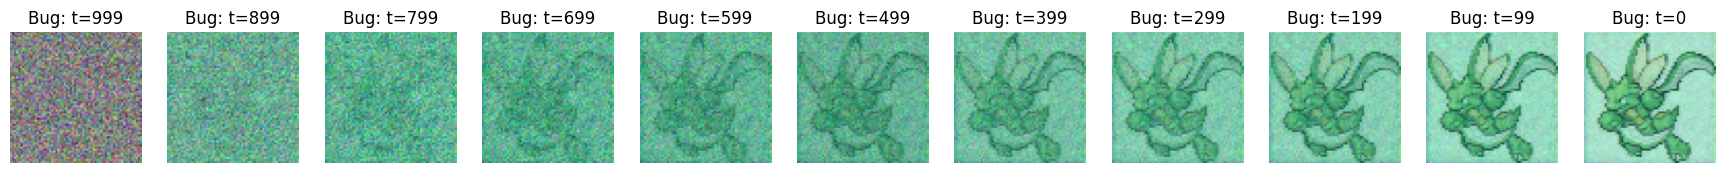

127/127 ━━━━━━━━━━━━━━━━━━━━ 104s 823ms/step - mae: 0.0484 - loss: 0.0068


In [12]:
diff_callback = DiffusionCallback(model, 20, onehot_to_string(label_example))
model.fit(dataset_overfitting, epochs=EPOCHS, callbacks=[diff_callback])

Generating sample 1/6


Sampling sprite...: 100%|██████████| 999/999 [01:23<00:00, 11.98it/s]


Generating sample 2/6


Sampling sprite...: 100%|██████████| 999/999 [01:24<00:00, 11.88it/s]


Generating sample 3/6


Sampling sprite...: 100%|██████████| 999/999 [01:23<00:00, 11.99it/s]


Generating sample 4/6


Sampling sprite...: 100%|██████████| 999/999 [01:23<00:00, 11.98it/s]


Generating sample 5/6


Sampling sprite...: 100%|██████████| 999/999 [01:23<00:00, 11.90it/s]


Generating sample 6/6


Sampling sprite...: 100%|██████████| 999/999 [01:23<00:00, 12.01it/s]


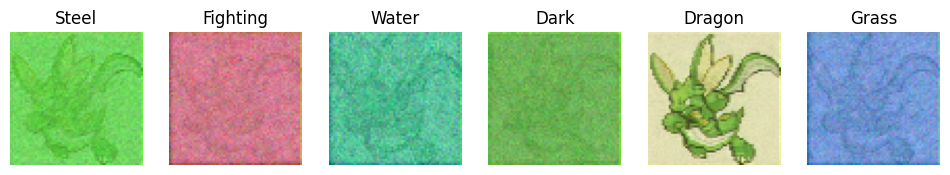

In [13]:
model.plot_samples(6)

Generating sample 1/1


Sampling sprite...: 100%|██████████| 999/999 [01:23<00:00, 11.97it/s]


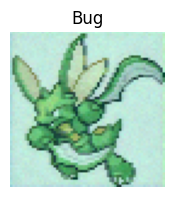

In [14]:
model.plot_samples(1, onehot_to_string(label_example))